In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install triton
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 3.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82

In [3]:
import torch
import triton
import triton.language as tl

DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')

In [4]:
def get_gpu_properties(device=DEVICE)->dict:
    props = triton.runtime.driver.active.utils.get_device_properties(device.index)
    return {"NUM_SM":props['multiprocessor_count'],"NUM_REGS":props['max_num_regs'],
           "TOTAL_SRAM_PER_SM":props['max_shared_mem'],"WARP_SIZE":props['warpSize']}



def choose_num_warps(block_size:int)->int:
    if block_size<2048:
        return 4
    if block_size<4096:
        return 8
    else:
        return 16

def choose_num_stages(total_sram_per_sm:int)->int:
    return 4 if total_sram_per_sm>=200_000 else 2


def launch_grid(n_rows:int,n_regs:int,sram_per_program:int,num_warps:int,hw:dict):
    """
    Helps us decide how many Triton programs to launch
    COMPUTES THE GRID SIZE 
    
    """
    NUM_SM = hw['NUM_SM'] #no of sm's in your gpu
    NUM_REGS = hw['NUM_REGS'] #total no of regs per sm
    TOTAL_SRAM_PER_SM = hw['TOTAL_SRAM_PER_SM'] #total sram per sm
    WARP_SIZE = hw['WARP_SIZE'] #warp size (a warp is a collective work of cores/threads one warp ==32 threads) this is a size of warp 
    reg_per_program = max(1,n_regs*WARP_SIZE*num_warps) #here n_regs is regs we are allocating and num_warps is warps we want this is total regs we need per total program warp size is num of threads *32*num_warps
    reg_occupancy = max(1,NUM_REGS // reg_per_program) # this is how many program we can fit due to reg num
    reg_occupancy = max(1,reg_occupancy) #if reg_per_program >> NUM_REGS (this is a problem we set 1 to not let 0)
    sram_occupancy = TOTAL_SRAM_PER_SM // max(1,sram_per_program) # how many progs can fit as per SRAM need
    sram_occupancy = max(1,sram_occupancy)
    programs_per_sm = min(reg_occupancy,sram_occupancy) #its min because if one is small we cant run more than that many programs 
    num_programs = min(NUM_SM*programs_per_sm,n_rows) #if our rows are less we can just limit by rows why run extra and if rows exceed we have to chunk as we are limited by sm count 
    return (int(num_programs),1,1)
    

@triton.jit
def _softmax_kernel(
    input_ptr,output_ptr,
    input_row_stride,output_row_stride,
    n_rows,n_cols,BLOCK_SIZE:tl.constexpr,num_stages:tl.constexpr,
):
    row_start = tl.program_id(0) #this is program id (each sm runs multiple programs) but prog id helps us with what row of data we are processing 
    row_step = tl.num_programs(0) #since we are running many programs we cant use next row for this prog we need to step ahead to get row for this prog to process 
    col_offsets = tl.arange(0,BLOCK_SIZE) #this is next power of 2 so each row processing as many cols it can with some extra with next power of 2 

    for row_idx in tl.range(row_start,n_rows,row_step,num_stages=num_stages):
        row_ptr  = input_ptr+(row_idx*input_row_stride)
        mask = col_offsets<n_cols
        row = tl.load(row_ptr+col_offsets,mask=mask,other=float('-inf')) #load to sram from dram
        #compute softmax in sram
        row_minus_max = row-tl.max(row,axis=0)
        num = tl.exp(row_minus_max)
        denom = tl.sum(num,axis=0)
        softmax_row = num/denom

        out_ptr = output_ptr+(row_idx*output_row_stride)
        tl.store(out_ptr+col_offsets,softmax_row,mask=mask)


def softmax(x:torch.Tensor):
    assert x.ndim==2
    M,N = x.shape

    BLOCK_SIZE = triton.next_power_of_2(N) #we load 2 to the power n next so if we have 5 we would load 8 elements 
    hw = get_gpu_properties()
    num_warps = choose_num_warps(BLOCK_SIZE)
    num_stages = choose_num_stages(hw['TOTAL_SRAM_PER_SM'])
    y = torch.empty_like(x)

    kernel = _softmax_kernel.warmup(
        x,y,x.stride(0),y.stride(0),M,N,BLOCK_SIZE=BLOCK_SIZE,num_stages=num_stages,num_warps=num_warps,grid=(1,)
    )
    kernel._init_handles()
    n_regs_per_program = kernel.n_regs
    sram_per_program = kernel.metadata.shared
    grid  = launch_grid(M,n_regs_per_program,sram_per_program,num_warps,hw)

    _softmax_kernel[grid](
        x,y,x.stride(0),y.stride(0),M,N,BLOCK_SIZE = BLOCK_SIZE,
        num_stages = num_stages,
        num_warps  = num_warps,BLOCK_SIZE=BLOCK_SIZE, num_stages=num_stages
    )
    return y
    



    
def naive_softmax(x:torch.Tensor):
    #take in a tensor of shape m*n and does softmax on it 
    row_max = x.max(dim=1)[0] # loaded m*n and saved n
    x = x - row_max.unsqueeze(1) #loaded m*n+n and saved m*n
    numerator = torch.exp(x) #load m*n save m*n
    denominator = numerator.sum(dim=1) #load m*n save n
    softmax_out = numerator/denominator.unsqueeze(1) #load m*n+n and save m*n
    return softmax_out #so in total we did memory reads of 8mn+3n memory r/w 
    
    

{'NUM_SM': 56, 'NUM_REGS': 65536, 'TOTAL_SRAM_PER_SM': 49152, 'WARP_SIZE': 32}


In [5]:
def test_softmax(M:int,N:int,atol=1e-6,rtol=1e-6,device='cuda'):
    torch.manual_seed(0)
    x = torch.randn(M,N).to(device)
    out_our  = softmax(x)
    out_torch = torch.softmax(x,dim=1)
    torch.testing.assert_close(out_our,out_torch,atol=atol,rtol=rtol)
    print('PASSED')

test_softmax(100,100)

PASSED


In [8]:
import time
import triton.testing as ttest


def bench_one(fn,warmup_time=10,reps=100):
    for _ in range(warmup_time):
        fn()
    torch.cuda.synchronize()
    start_time = time.time()
    for _ in range(reps):
        fn()
    torch.cuda.synchronize()
    end_time = time.time()
    return (end_time-start_time)*1e-3/reps

def gbps(ms,tensor):
    return 2*tensor.numel()*tensor.element_size()*1e-9/(ms*1e-3)

In [22]:
M, N = 4096, 2048
x=torch.randn(M,N).to(DEVICE)
ms_torch = bench_one(lambda:torch.softmax(x,dim=1))
ms_triton = bench_one(lambda:softmax(x))
ms_naive_softmax = bench_one(lambda:naive_softmax(x))



In [23]:
ms_triton,ms_torch,ms_naive_softmax

(2.1752357482910158e-07, 2.550911903381348e-07, 5.664968490600586e-07)

In [26]:
print(f"Torch   : {ms_torch:6.2f} ms  | {gbps(ms_torch,  x):5.1f} GB/s")
print(f"Triton  : {ms_triton:6.2f} ms  | {gbps(ms_triton, x):5.1f} GB/s")

Torch   :   0.00 ms  | 263077936.6 GB/s
Triton  :   0.00 ms  | 308513061.4 GB/s


In [37]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[128 * i for i in range(2, 100)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel="GB/s",
        plot_name="softmax-performance",
        args={'M': 4096},
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: naive_softmax(x))
    else:
        ms = triton.testing.do_bench(lambda: softmax(x))

    return ms

softmax-performance:
          N    Triton     Torch
0     256.0  0.025885  0.097608
1     384.0  0.030793  0.132965
2     512.0  0.038507  0.166016
3     640.0  0.048233  0.199348
4     768.0  0.055677  0.230859
5     896.0  0.063719  0.262713
6    1024.0  0.071023  0.295045
7    1152.0  0.088112  0.327198
8    1280.0  0.096218  0.356781
9    1408.0  0.103708  0.392250
10   1536.0  0.111188  0.420834
11   1664.0  0.119202  0.452062
12   1792.0  0.126695  0.483797
13   1920.0  0.134589  0.517098
14   2048.0  0.142159  0.546793
15   2176.0  0.147608  0.580207
16   2304.0  0.154492  0.607822
17   2432.0  0.162490  0.641479
18   2560.0  0.169920  0.677267
19   2688.0  0.177663  0.705016
20   2816.0  0.185019  0.740984
21   2944.0  0.192368  0.768323
22   3072.0  0.199956  0.800540
23   3200.0  0.207456  0.831712
24   3328.0  0.215615  0.856472
25   3456.0  0.223662  0.896349
26   3584.0  0.231209  0.929609
27   3712.0  0.239037  0.967157
28   3840.0  0.247167  0.996485
29   3968.0  0.2549

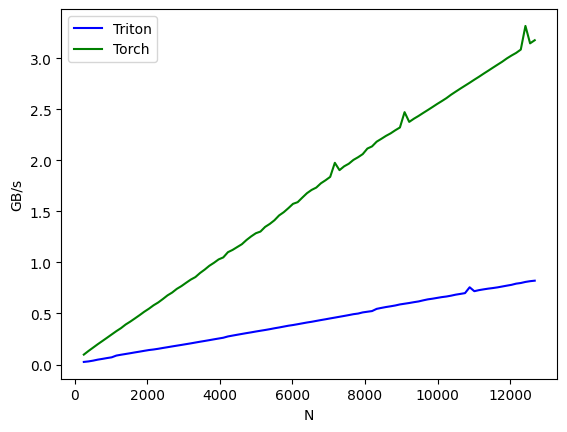

In [38]:
benchmark.run(print_data=True)   # prints a table, renders the plot inline
